# Description

It runs DBSCAN on the `pca` version of the data.

The notebook explores different values for `min_samples` and `eps` (the main parameters of DBSCAN).

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: pca

## Settings

In [6]:
INPUT_SUBSET = "pca"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
# parameters of the dimentionality reduction steps
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

In [10]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

## Load input file

In [11]:
data = pd.read_pickle(input_filepath)

In [12]:
data.shape

(3749, 50)

In [13]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,-0.547515,-0.007250,0.245361,0.132424,1.201447,-0.113158,0.048859,1.031679,0.711208,0.126100,...,0.113685,-0.109753,0.178202,-0.487868,1.805920,-0.342611,-0.663712,-1.313987,-1.481707,0.396410
100002_raw-Energy,-1.570593,-0.618992,-1.223395,1.627321,-0.563860,0.224922,-1.500327,2.045633,-1.665998,-0.180432,...,0.697880,1.412676,2.103988,0.385625,2.386495,-2.939998,-0.978275,-1.893307,-0.259497,0.423264
100003_raw-Protein,-0.601212,-0.948824,-1.022209,2.438433,-2.062235,0.356202,-1.538038,2.314675,-1.108991,0.318034,...,0.171992,1.351979,0.054404,-0.725132,2.226520,-3.481674,-0.445294,-0.477452,0.237157,1.440867
100004_raw-Fat,-1.648214,-0.342042,-0.270189,1.683268,-1.222401,0.018349,-0.032824,1.671161,-0.908965,0.224100,...,-0.358812,0.696836,1.072624,0.627951,1.802000,0.174704,0.826319,-0.826992,0.596113,0.620050
100005_raw-Carbohydrate,-1.867586,-0.006412,-0.303220,0.770958,-0.116822,0.460946,-2.407732,1.534273,-1.930577,0.064621,...,1.332852,1.978032,2.158456,0.831123,1.093202,-3.539033,-0.831862,-0.842298,-0.723072,0.359438


In [14]:
assert not data.isna().any().any()

## Tests different k values (k-NN)

In [15]:
k_values = np.arange(2, 100 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100)

In [16]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [17]:
min_max_range = (15, 80)

eps_range_per_k = {k: min_max_range for k in k_values}
eps_range_per_k_to_explore = {k: min_max_range for k in k_values_to_explore}

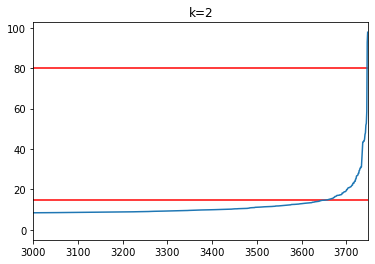

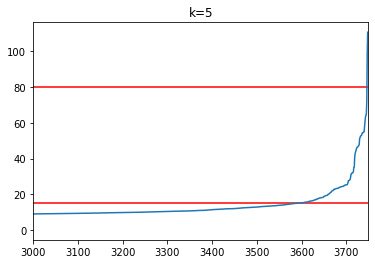

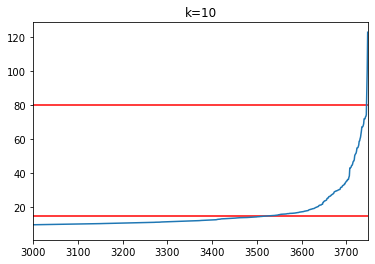

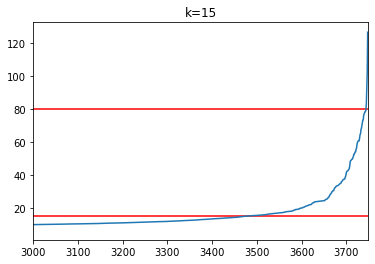

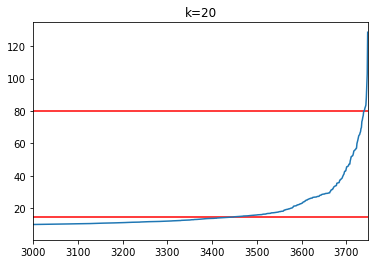

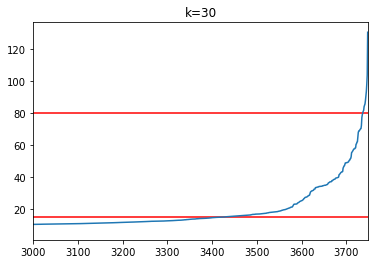

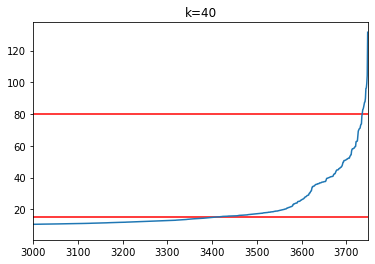

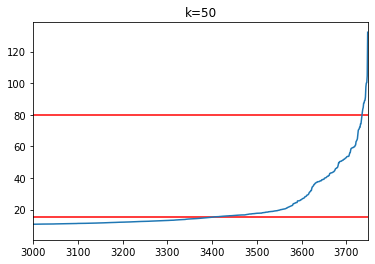

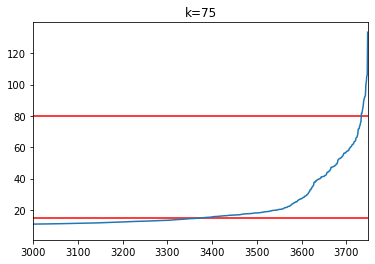

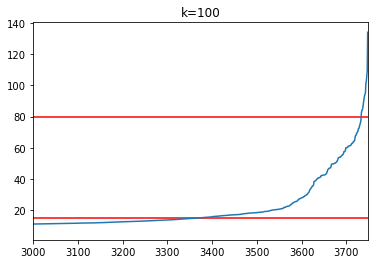

In [18]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

## Clustering

### Generate clusterers

In [19]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100]),
 'EPS_RANGE_PER_K': {2: (15, 80),
  3: (15, 80),
  4: (15, 80),
  5: (15, 80),
  6: (15, 80),
  7: (15, 80),
  8: (15, 80),
  9: (15, 80),
  10: (15, 80),
  11: (15, 80),
  12: (15, 80),
  13: (15, 80),
  14: (15, 80),
  15: (15, 80),
  16: (15, 80),
  17: (15, 80),
  18: (15, 80),
  19: (15, 80),
  20: (15, 80),
  21: (15, 80),
  22: (15, 80),
  23: (15, 80),
  24: (15, 80),
  25: (15, 80),
  26: (15, 80),
  27: (15, 80),
 

In [20]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [21]:
display(len(CLUSTERERS))

3267

In [22]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=15.0, metric='precomputed', min_samples=2, n_jobs=3))

('DBSCAN #1',
 DBSCAN(eps=17.03125, metric='precomputed', min_samples=2, n_jobs=3))

In [23]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

### Generate ensemble

In [24]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [25]:
data_dist.shape

(3749, 3749)

In [26]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14055001.0
mean     17.536786666895573
std      14.914704903599608
min                     0.0
25%      11.028118338431472
50%      12.507491786104163
75%      16.607661053517283
max      160.45156459412453
dtype: object

In [27]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 3267/3267 [10:52<00:00,  5.01it/s]


In [28]:
ensemble.shape

(245, 3)

In [29]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 15.0, 'leaf_size'...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",39
DBSCAN #1,"{'algorithm': 'auto', 'eps': 17.03125, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",29
DBSCAN #2,"{'algorithm': 'auto', 'eps': 19.0625, 'leaf_si...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
DBSCAN #3,"{'algorithm': 'auto', 'eps': 21.09375, 'leaf_s...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",26
DBSCAN #4,"{'algorithm': 'auto', 'eps': 23.125, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24


In [30]:
ensemble["n_clusters"].value_counts().head()

2    84
3    56
5    30
4    16
6    13
Name: n_clusters, dtype: int64

In [31]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    245.000000
mean       5.057143
std        5.110741
min        2.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       39.000000
Name: n_clusters, dtype: float64

### Testing

In [32]:
assert ensemble_stats["min"] > 1

In [33]:
assert not ensemble["n_clusters"].isna().any()

In [34]:
# assert ensemble.shape[0] == len(CLUSTERERS)

In [35]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [36]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

### Save

In [37]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {},
        #         CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/DBSCAN.pkl')

In [38]:
ensemble.to_pickle(output_filename)